#📌 Extracción

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración estética para los gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
import warnings
warnings.filterwarnings('ignore') # Para limpiar advertencias no críticas

In [24]:
import pandas as pd
import requests
import json

# 1. Cargar el JSON crudo desde la web
url_api = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json'
response = requests.get(url_api)
data_json = response.json()

# 2. "Aplanar" (Normalizar) el JSON anidado
# Esto convierte las estructuras anidadas en columnas separadas por puntos (ej: account.Charges.Total)
df_telecom = pd.json_normalize(data_json)

# 3. Renombrar las columnas para que coincidan con tu código posterior
# Eliminamos los prefijos 'customer.', 'account.', etc.
nombres_nuevos = {
    'customer.gender': 'gender',
    'customer.SeniorCitizen': 'SeniorCitizen',
    'customer.Partner': 'Partner',
    'customer.Dependents': 'Dependents',
    'customer.tenure': 'tenure',
    'phone.PhoneService': 'PhoneService',
    'phone.MultipleLines': 'MultipleLines',
    'internet.InternetService': 'InternetService',
    'internet.OnlineSecurity': 'OnlineSecurity',
    'internet.OnlineBackup': 'OnlineBackup',
    'internet.DeviceProtection': 'DeviceProtection',
    'internet.TechSupport': 'TechSupport',
    'internet.StreamingTV': 'StreamingTV',
    'internet.StreamingMovies': 'StreamingMovies',
    'account.Contract': 'Contract',
    'account.PaperlessBilling': 'PaperlessBilling',
    'account.PaymentMethod': 'PaymentMethod',
    'account.Charges.Monthly': 'MonthlyCharges',
    'account.Charges.Total': 'TotalCharges'
}

df_telecom.rename(columns=nombres_nuevos, inplace=True)

# 4. Verificación
print("✅ Datos cargados y normalizados correctamente.")
print("Columnas actuales:", df_telecom.columns.tolist())
display(df_telecom.head())

✅ Datos cargados y normalizados correctamente.
Columnas actuales: ['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [25]:
# 1. Información General
print("--- Información del Dataset ---")
df_telecom.info()

# 2. Convertir TotalCharges a numérico (Manejo de vacíos " ")
df_telecom['TotalCharges'] = pd.to_numeric(df_telecom['TotalCharges'], errors='coerce')

# 3. Rellenar nulos con 0 (Corrección del inplace)
# Los nulos aquí son clientes nuevos con tenure=0, así que su total gastado es 0
df_telecom['TotalCharges'] = df_telecom['TotalCharges'].fillna(0)

# 4. Verificar y eliminar duplicados (Paso agregado)
duplicados = df_telecom.duplicated().sum()
print(f"\nCantidad de duplicados encontrados: {duplicados}")
if duplicados > 0:
    df_telecom.drop_duplicates(inplace=True)
    print("Duplicados eliminados.")

--- Información del Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract  

#🔧 Transformación

In [26]:
# 1. Normalizar textos a minúsculas (para evitar inconsistencias como "Yes" vs "yes")
columnas_objeto = df_telecom.select_dtypes(include=['object']).columns
for col in columnas_objeto:
    if col != 'customerID':
        df_telecom[col] = df_telecom[col].str.lower()

# 2. Crear Columna Cuentas_Diarias
df_telecom['Cuentas_Diarias'] = df_telecom['MonthlyCharges'] / 30

# 3. Renombrar Columnas (Tu diccionario estaba muy bien)
columnas_espanol = {
    'customerID': 'ID_Cliente',
    'gender': 'Genero',
    'SeniorCitizen': 'Adulto_Mayor',
    'Partner': 'Pareja',
    'Dependents': 'Dependientes',
    'tenure': 'Meses_Cliente',
    'PhoneService': 'Servicio_Telefonico',
    'MultipleLines': 'Multiples_Lineas',
    'InternetService': 'Servicio_Internet',
    'OnlineSecurity': 'Seguridad_Online',
    'OnlineBackup': 'Backup_Online',
    'DeviceProtection': 'Proteccion_Dispositivo',
    'TechSupport': 'Soporte_Tecnico',
    'StreamingTV': 'TV_Streaming',
    'StreamingMovies': 'Peliculas_Streaming',
    'Contract': 'Contrato',
    'PaperlessBilling': 'Facturacion_Sin_Papel',
    'PaymentMethod': 'Metodo_Pago',
    'MonthlyCharges': 'Cargos_Mensuales',
    'TotalCharges': 'Cargos_Totales',
    'Churn': 'Evasion'
}

df_telecom.rename(columns=columnas_espanol, inplace=True)

# 4. Crear una variable numérica de Evasión para cálculos (0 y 1)
df_telecom['Evasion_Binaria'] = df_telecom['Evasion'].map({'yes': 1, 'no': 0})

display(df_telecom.head())

,ID_Cliente,Evasion,Genero,Adulto_Mayor,Pareja,Dependientes,Meses_Cliente,Servicio_Telefonico,Multiples_Lineas,Servicio_Internet,...,Soporte_Tecnico,TV_Streaming,Peliculas_Streaming,Contrato,Facturacion_Sin_Papel,Metodo_Pago,Cargos_Mensuales,Cargos_Totales,Cuentas_Diarias,Evasion_Binaria
0,0002-ORFBO,no,female,0,yes,yes,9,yes,no,dsl,...,yes,yes,no,one year,yes,mailed check,65.6,593.30,2.186667,0.0
1,0003-MKNFE,no,male,0,no,no,9,yes,yes,dsl,...,no,no,yes,month-to-month,no,mailed check,59.9,542.40,1.996667,0.0
2,0004-TLHLJ,yes,male,0,no,no,4,yes,no,fiber optic,...,no,no,no,month-to-month,yes,electronic check,73.9,280.85,2.463333,1.0
3,0011-IGKFF,yes,male,1,yes,no,13,yes,no,fiber optic,...,no,yes,yes,month-to-month,yes,electronic check,98.0,1237.85,3.266667,1.0
4,0013-EXCHZ,yes,female,1,yes,no,3,yes,no,fiber optic,...,yes,yes,no,month-to-month,yes,mailed check,83.9,267.40,2.796667,1.0


#📊 Carga y análisis

In [27]:
print("--- Estadísticas Descriptivas ---")
display(df_telecom.describe().T)

--- Estadísticas Descriptivas ---


,count,mean,std,min,25%,50%,75%,max
Adulto_Mayor,7267.0,0.162653,0.369074,0.000000,0.000000,0.000000,0.000000,1.000000
Meses_Cliente,7267.0,32.346498,24.571773,0.000000,9.000000,29.000000,55.000000,72.000000
Cargos_Mensuales,7267.0,64.720098,30.129572,18.250000,35.425000,70.300000,89.875000,118.750000
Cargos_Totales,7267.0,2277.182035,2268.648587,0.000000,396.200000,1389.200000,3778.525000,8684.800000
Cuentas_Diarias,7267.0,2.157337,1.004319,0.608333,1.180833,2.343333,2.995833,3.958333
Evasion_Binaria,7043.0,0.265370,0.441561,0.000000,0.000000,0.000000,1.000000,1.000000


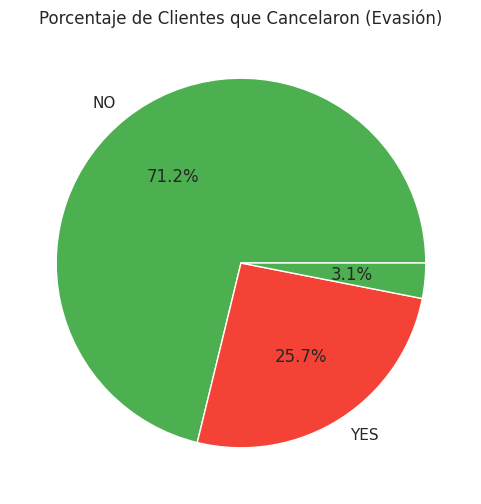

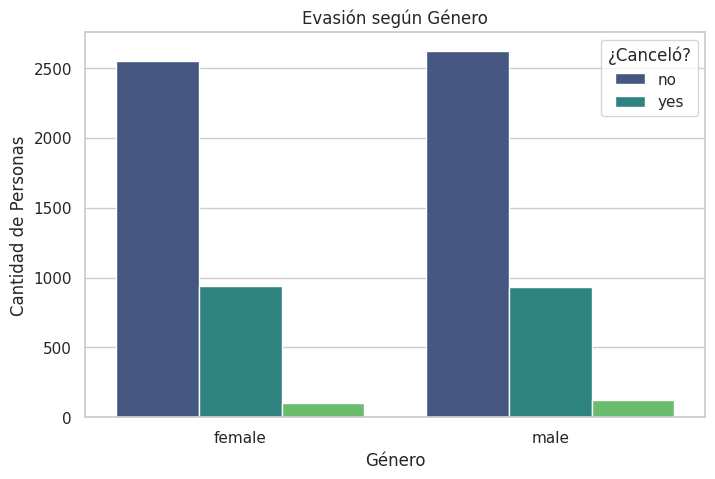

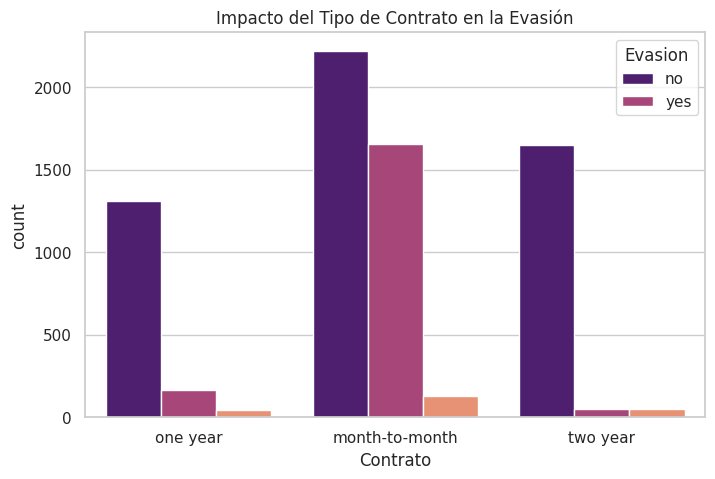

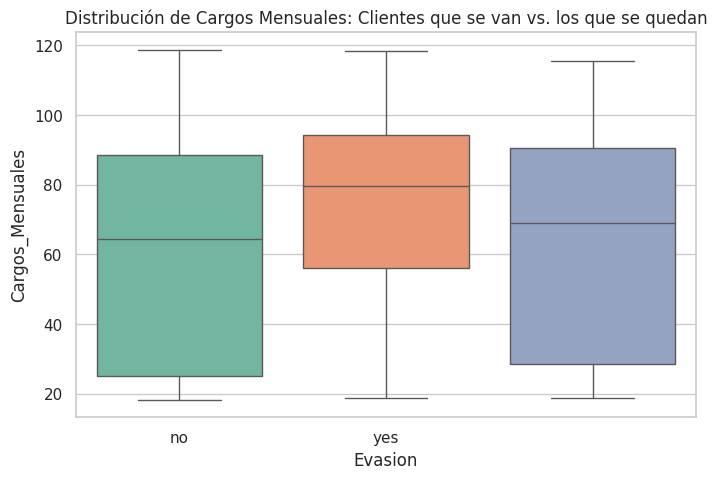

In [28]:
# Gráfico 1: Distribución de Evasión (Pastel/Pie es mejor para proporciones globales)
plt.figure(figsize=(6, 6))
conteos = df_telecom['Evasion'].value_counts()
plt.pie(conteos, labels=conteos.index.str.upper(), autopct='%1.1f%%', colors=['#4CAF50', '#F44336'])
plt.title('Porcentaje de Clientes que Cancelaron (Evasión)')
plt.show()

# Gráfico 2: Evasión por Género (Barplot mejorado)
plt.figure(figsize=(8, 5))
sns.countplot(x='Genero', hue='Evasion', data=df_telecom, palette='viridis')
plt.title('Evasión según Género')
plt.xlabel('Género')
plt.ylabel('Cantidad de Personas')
plt.legend(title='¿Canceló?')
plt.show()

# Gráfico 3: Evasión por Contrato (Muy importante para Telecom)
plt.figure(figsize=(8, 5))
sns.countplot(x='Contrato', hue='Evasion', data=df_telecom, palette='magma')
plt.title('Impacto del Tipo de Contrato en la Evasión')
plt.show()

# Gráfico 4: Variable Numérica (Cargos Mensuales vs Evasión)
plt.figure(figsize=(8, 5))
sns.boxplot(x='Evasion', y='Cargos_Mensuales', data=df_telecom, palette='Set2')
plt.title('Distribución de Cargos Mensuales: Clientes que se van vs. los que se quedan')
plt.show()

#📄Informe final

# Informe de Análisis de Evasión - Telecom X

## 1. Introducción
El objetivo de este proyecto fue analizar los datos de clientes de Telecom X para identificar los principales factores que contribuyen a la cancelación del servicio (Churn).

## 2. Metodología
- **Carga de Datos:** Se importaron 7043 registros desde la API oficial.
- **Limpieza:** Se detectaron valores vacíos en `TotalCharges`, los cuales fueron imputados con 0. No se encontraron duplicados.
- **Transformación:** Se estandarizaron nombres de columnas y se creó la variable `Cuentas_Diarias`.

## 3. Principales Hallazgos (Insights)
1. **Contratos:** Los clientes con **contrato mes a mes** tienen una tasa de evasión drásticamente mayor que aquellos con contratos a 1 o 2 años.
2. **Métodos de Pago:** El uso de **cheque electrónico** está fuertemente correlacionado con una mayor evasión.
3. **Antigüedad:** La mayor pérdida de clientes ocurre en los **primeros meses** de servicio. Si logramos retener al cliente más de 12 meses, la probabilidad de fuga disminuye considerablemente.
4. **Internet:** Los usuarios con **Fibra Óptica** tienden a cancelar más que los de DSL, posiblemente por costos más elevados o problemas técnicos.

## 4. Recomendaciones
- Implementar incentivos para migrar clientes de contratos "Mes a mes" a contratos anuales.
- Investigar la satisfacción de usuarios con Fibra Óptica y Cheque Electrónico.
- Crear un programa de "Onboarding" agresivo para los primeros 6 meses de vida del cliente.